In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# raw dataframe
df0 = pd.read_excel('../data/pone.0183228.s006.xlsx', sheet_name='plasma', header = None, skip = 1)

# remove unnecessary rows and columns
platform = df0.iloc[1, :]
level_of_identification = df0.iloc[4, :]
units = df0.iloc[5, :]
df = df0.drop(index = [0, 1, 2, 4, 5])

df.iloc[0, :][0:3] = ['Sex', 'Age', 'Menopause']
df.columns = np.array(df.iloc[0,:])
df.drop(index = 3, inplace = True)
df.index = np.arange(len(df))
Age, Sex, Menopause = df.Age, df.Sex, df.Menopause
df.drop(['variable long name'], axis = 1, inplace = True)
df.head()

,Sex,Age,Menopause,Carnitine,Betaine,Choline,Dimethyl-glycine,Sarcosine,Trimethyl-amine-N-oxide,Carnitine,...,linolenic acid,eicosadienoic acid,dihomo-γ-linolenic acid,behenic acid,arachidonic acid,eicosapentaenoic acid,lignoceric acid,docosatetraenoic acid,docosapentaenoic acid,docosahexaenoic acid
0,1,66.3682,NaN,35.23,40.5,9.33,3,4.92,2.71,33.3716,...,12.9769,6.42583,52.5943,1.79579,223.444,20.1033,2.04693,8.74794,16.2559,31.796
1,1,23.6449,NaN,35.91,46.89,10.46,2.64,2.21,2.31,38.2747,...,14.8863,5.32614,43.4748,1.10423,202.725,20.5065,0.48,7.55581,16.8608,28.7924
2,1,50.987,NaN,48.71,28.48,11.26,2.38,2.97,13.98,53.419,...,9.17422,3.23201,24.851,1.29035,120.742,7.9553,0.48,4.30479,9.01177,34.1674
3,1,23.3684,NaN,27.14,42.01,9.26,2.86,3,3.72,25.6593,...,11.9528,4.96358,35.5244,0.48,146.83,22.383,0.48,5.1504,15.4226,48.8507
4,1,57.3101,NaN,33.28,35.71,9.38,2.82,1.69,3.57,38.9843,...,16.9805,6.28118,51.4516,1.99483,159.292,16.4726,2.48512,7.73774,19.4649,40.9011


In [5]:
df.shape

(308, 444)

In [7]:
# write the dataframe to csv format
df.to_csv('../steps/rawdf.csv')

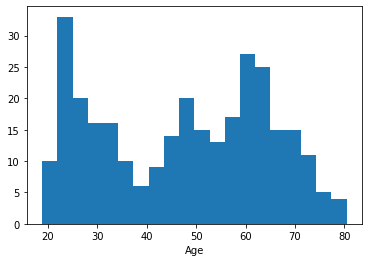

In [5]:
# Age distribution
sns.distplot(Age.dropna(), kde = False, bins = 20, hist_kws=dict(alpha=1));

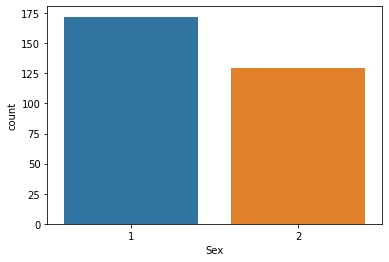

In [4]:
# Sex distribution
sns.countplot(Sex); # 1 is male, 2 is female

# Training/Test sets

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
def strat_split(df, response):
    '''Performes Stratified sampling and returns Training and Test set'''
    split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 5)
    for train_ind, test_ind in split.split(df, response):
        train_df = df.iloc[train_ind]
        test_df = df.iloc[test_ind]
    return train_df, test_df

## Sex

"For the prediction of sex, due to the relatively low number of young females compared to young men, only participants in the age range of 36–80 were included. In this age range the number of males and females is comparable (n = 99 and n = 101, respectively)."

In [6]:
sex_df = df.copy()
sex_df = sex_df.query('Age >=36 & Age <= 80')
sex_df.drop(['Menopause', 'Age'], axis = 1, inplace = True)
sex_df = sex_df.reset_index().drop('index', axis = 1)

#### Missing values

In [7]:
sex_df.apply(lambda x: np.sum(x.isnull()), axis = 0).value_counts()

1    312
9    129
0      1
dtype: int64

In [8]:
print(sex_df.shape)
print(sex_df.dropna().shape)

(199, 442)
(190, 442)


This means that all `NAs` are in the same individuals. So we can remove them 

In [13]:
sex_df.dropna(inplace=True)

In [9]:
# Train/Test set generator
train_df_sex, test_df_sex = strat_split(sex_df, sex_df.Sex)

In [12]:
train_df_sex.to_csv('data/train_df_sex.csv')
test_df_sex.to_csv('data/test_df_sex.csv')

## Age

In [11]:
male_age = df.query('Sex == 1').drop(['Sex', 'Menopause'], axis = 1)
female_age = df.query('Sex == 2').drop(['Sex', 'Menopause'], axis = 1)
female_age_m = df.query('Sex == 2').drop(['Sex'], axis = 1) # for menopausal status

I have to create a categorical variable from `Age` and than perform StratifiedSampling on it

In [12]:
print(male_age.shape)
print(male_age.dropna().shape)

(172, 442)
(170, 442)


In [13]:
print(female_age.shape)
print(female_age.dropna().shape)

(129, 442)
(121, 442)


In [16]:
print(female_age_m.shape)
print(female_age_m.dropna().shape)

(121, 443)
(121, 443)


There are two males and 8 females with missing values. Lets remove them

In [14]:
male_age.dropna(inplace=True)
female_age.dropna(inplace=True)
#female_age_m.dropna(inplace=True) # Not neccessary

In [17]:
def age_prep(df0):
    '''Label discretization, which is neccessary for Stratified Sampling. Returns Train and Test dataset'''
    df = df0.copy()
    age_cat = []
    q = df.Age.quantile(q = [0.2, 0.4, 0.6, 0.8])
    for i in df.Age:
        if i <= np.ceil(q[0.2]): age_cat.append(1)
        elif i > np.ceil(q[0.2]) and i <= np.ceil(q[0.4]): age_cat.append(2)
        elif i > np.ceil(q[0.4]) and i <= np.ceil(q[0.6]): age_cat.append(3)
        elif i > np.ceil(q[0.6]) and i <= np.ceil(q[0.8]): age_cat.append(4)
        elif i > np.ceil(q[0.8]): age_cat.append(5)
    df['Age_cat'] = age_cat
    train_df, test_df = strat_split(df, df['Age_cat'])
    train_df.drop('Age_cat', axis = 1, inplace = True)
    test_df.drop('Age_cat', axis = 1, inplace = True)
    return train_df, test_df

In [16]:
train_df_male_age, test_df_male_age = age_prep(male_age)
train_df_female_age, test_df_female_age = age_prep(female_age)
train_df_male_age.to_csv('../steps/train_df_male_age.csv')
test_df_male_age.to_csv('../steps/test_df_male_age.csv')
train_df_female_age.to_csv('../steps/train_df_female_age.csv')
test_df_female_age.to_csv('../steps/test_df_female_age.csv')

/home/tomas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/tomas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
train_df_female_age_m, test_df_female_age_m = age_prep(female_age_m)
train_df_female_age_m.to_csv('../steps/train_df_female_age_m.csv')
test_df_female_age_m.to_csv('../steps/test_df_female_age_m.csv')

/home/tomas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Menopausal Status

In [18]:
meno_df = df.query('Sex == 2').drop(['Sex', 'Age'], axis = 1)

In [19]:
print(meno_df.shape)
print(meno_df.dropna().shape)

(129, 442)
(121, 442)


In [20]:
meno_df.dropna(inplace=True)

In [21]:
train_df_meno, test_df_meno = strat_split(meno_df, meno_df.Menopause)

In [22]:
train_df_meno.to_csv('data/train_df_meno.csv')
test_df_meno.to_csv('data/test_df_meno.csv')